In [1]:
import os
import pymaid
import logging
import pandas as pd
import numpy as np
import networkx as nx
from itertools import chain, combinations
from upsetplot import plot
from matplotlib import pyplot as plt
from networkx import from_numpy_array, number_of_nodes, number_of_edges, density
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.layouts import layout_tsne, layout_umap
from graspologic.plot.plot import networkplot
from graspologic.utils import is_fully_connected, largest_connected_component, is_symmetric, symmetrize

In [33]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

path = "/Users/kareefullah/Desktop/neurodata/neurodata/platy-data"

In [3]:
skids_orig = pymaid.get_skids_by_annotation("connectome")

In [35]:
#original dataframe adjacency matrix and skids
adj_df_orig = pymaid.adjacency_matrix(skids_orig)
g = nx.from_pandas_adjacency(adj_df_orig, create_using=nx.DiGraph)
nx.write_edgelist(g, path + "/docs/outputs/weighted_edgelist.csv")

In [5]:
#numpy representation of original graph
adj_numpy_orig = adj_df_orig.to_numpy()

#numpy largest connected component
adj_numpy_lcc, new_inds = largest_connected_component(adj_numpy_orig, return_inds=True)

#get skids of nodes in lcc
skids_lcc = adj_df_orig.index[new_inds]

#pandas largest connected component
#adj_df_lcc = adj_df_orig.iloc[inds].iloc[:, inds]

In [6]:
#symmetrized version of numpy_lcc
adj_numpy_sym_lcc = symmetrize(adj_numpy_lcc)

#networkx representation of symmetrized lcc graph
adj_nx_sym_lcc = nx.from_numpy_array(adj_numpy_sym_lcc, create_using=nx.DiGraph)
print(adj_nx_sym_lcc)

DiGraph with 2723 nodes and 21691 edges


In [7]:
#use layout_tsne to get 2d representation of graph
X, node_pos = layout_tsne(adj_nx_sym_lcc, perplexity=100, n_iter=10000)
x_pos = []
y_pos = []
node_comms = []
for pos in node_pos:

    #save the assigned community of the node
    node_comms.append(pos[4])
    x_pos.append(pos[1])
    y_pos.append(pos[2])

node_comms = np.array(node_comms)
x_pos = np.array(x_pos)
y_pos = np.array(y_pos)
degrees = np.sum(adj_numpy_sym_lcc, axis=0)

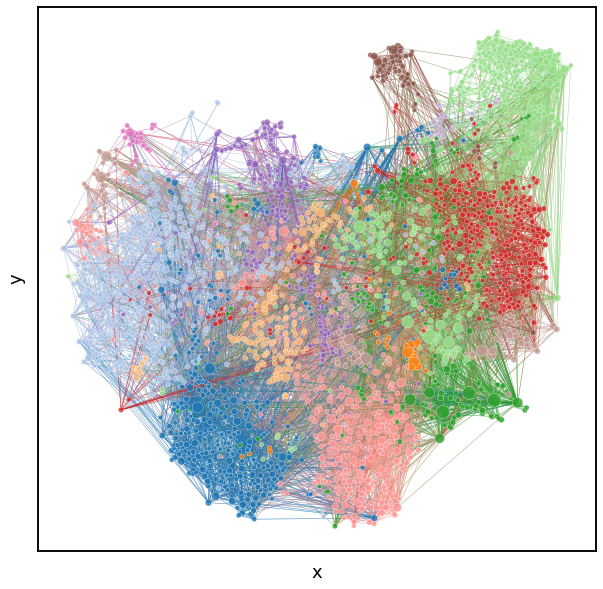

In [8]:
plot = networkplot(
    adjacency=adj_numpy_sym_lcc,
    x=x_pos,
    y=y_pos,
    node_hue=node_comms,
    palette="tab20",
    node_size=degrees,
    node_sizes=(20, 200),
    edge_hue="source",
    edge_alpha=0.5,
    edge_linewidth=0.5,
)
my_path = os.path.abspath("/Users/kareefullah/Desktop/neurodata/neurodata/platy-data")
plt.savefig(my_path + "/docs/outputs/tsne_connectome.png")
plt.show()

In [9]:
#use layout_tsne to get 2d representation of graph
X, node_pos = layout_umap(adj_nx_sym_lcc)
x_pos = []
y_pos = []
node_comms = []
for pos in node_pos:
    node_comms.append(pos[4])
    x_pos.append(pos[1])
    y_pos.append(pos[2])

node_comms = np.array(node_comms)
x_pos = np.array(x_pos)
y_pos = np.array(y_pos)
degrees = np.sum(adj_numpy_sym_lcc, axis=0)

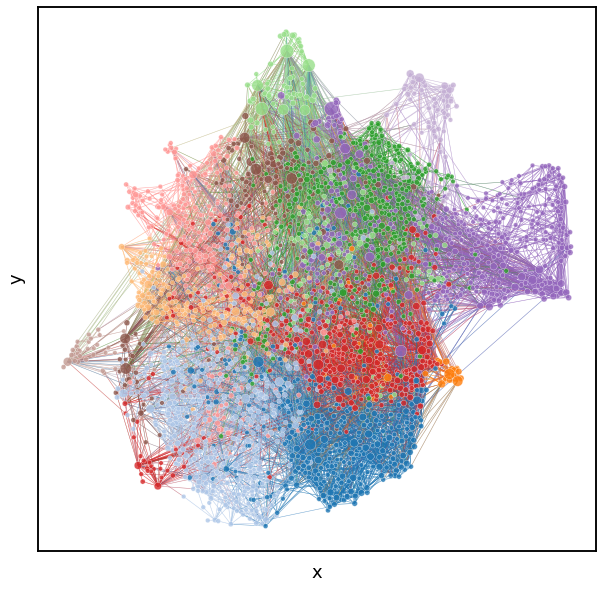

In [10]:
plot = networkplot(
    adjacency=adj_numpy_sym_lcc,
    x=x_pos,
    y=y_pos,
    node_hue=node_comms,
    palette="tab20",
    node_size=degrees,
    node_sizes=(20, 200),
    edge_hue="source",
    edge_alpha=0.5,
    edge_linewidth=0.5,
)
my_path = os.path.abspath("/Users/kareefullah/Desktop/neurodata/neurodata/platy-data")
plt.savefig(my_path + "/docs/outputs/umap_connectome.png")
plt.show()

In [11]:
#given the adjacency matrix and a partition of the nodes return the modularity score
def modularity_from_adjacency(sym_adj, partition, resolution=1):
    if isinstance(partition, dict):
        partition_labels = np.vectorize(partition.__getitem__)(
            np.arange(sym_adj.shape[0])
        )
    else:
        partition_labels = partition
    partition_labels = np.array(partition_labels)
    in_comm_mask = partition_labels[:, None] == partition_labels[None, :]
    degrees = np.squeeze(np.asarray(sym_adj.sum(axis=0)))
    degree_prod_mat = np.outer(degrees, degrees) / sym_adj.sum()
    mod_mat = sym_adj - resolution * degree_prod_mat
    return mod_mat[in_comm_mask].sum() / sym_adj.sum()

In [26]:
#get original networkx graph (not lcc)
adj_nx_orig = nx.from_numpy_array(adj_numpy_orig, create_using=nx.DiGraph)

#stats on original graph
n_nodes_orig = adj_nx_orig.number_of_nodes()
n_edges_orig = adj_nx_orig.number_of_edges()
dens_orig = density(adj_nx_orig)

#cannot calc modularity because there are isolate nodes
mod_score_orig = "N/A"

avg_degree_orig = np.average(np.count_nonzero(adj_numpy_orig, axis=0))
avg_degree_orig

4.234237536656892

In [27]:
#get non-symmetrized lcc networkx graph
adj_nx_lcc = nx.from_numpy_array(adj_numpy_lcc, create_using=nx.DiGraph)

#stats on lcc adj
n_nodes_lcc = adj_nx_lcc.number_of_nodes()
n_edges_lcc = adj_nx_lcc.number_of_edges()
dens_lcc = density(adj_nx_lcc)

#make symmetric when calc mod
sym_adj_lcc = symmetrize(adj_numpy_lcc)
mod_score_lcc = modularity_from_adjacency(sym_adj_lcc, node_comms)

avg_degree_lcc = np.average(np.count_nonzero(adj_numpy_lcc, axis=0))

In [28]:
#paper stats
n_nodes_paper = 2728
n_edges_paper = 11437
dens_paper = 0.0015
mod_score_paper = 0.62
avg_degree_paper = 4.1

In [29]:
stats = {"Number of nodes": [n_nodes_orig, n_nodes_lcc, n_nodes_paper], "Number of edges": [n_edges_orig, n_edges_lcc, n_edges_paper], "Graph density": [dens_orig, dens_lcc, dens_paper], "Modularity": [mod_score_orig, mod_score_lcc, mod_score_paper], "Avg. degree": [avg_degree_orig, avg_degree_lcc, avg_degree_paper]}
stats_df = pd.DataFrame.from_dict(stats, orient="index", columns=["Orig adj", "LCC adj", "Paper"])
stats_df

,Orig adj,LCC adj,Paper
Number of nodes,2728,2723.000000,2728.0000
Number of edges,11551,11551.000000,11437.0000
Graph density,0.001553,0.001558,0.0015
Modularity,N/A,0.645892,0.6200
Avg. degree,4.234238,4.242012,4.1000
